In [1]:
%matplotlib inline

In [43]:
import os
os.chdir("/home/jptalusan/mta_stationing_problem")
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error

from pyspark.sql import functions as F
from ast import literal_eval
import sys
from tqdm import tqdm
print(os.getcwd())
from src.config import *
from pandas.core.common import SettingWithCopyWarning
from src import data_utils, triplevel_utils
from src import day_ahead_prediction_utils, any_day_prediction_utils
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
import xgboost as xgb
import importlib
importlib.reload(data_utils)
import matplotlib as mpl

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

/media/seconddrive/mta_stationing_problem


In [44]:
from pyspark.sql import Row, SparkSession
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()

In [46]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Plotting Same Day stop level evaluation

In [47]:
def get_mse(x, length=None):
    if not length:
        y_true = [int(float(y)) for y in x.y_true]
        y_pred = [int(float(y)) for y in x.y_pred]
    else:
        if len(x.y_true) < length:
            length = len(x.y_true)
        y_true = [int(float(y)) for y in x.y_true[0:length]]
        y_pred = [int(float(y)) for y in x.y_pred[0:length]]
        
    return mean_squared_error(y_true, y_pred, squared=False)
        

In [48]:
## Grid search
fp = os.path.join('models', 'same_day', 'gridsearch')
filenames= os.listdir(fp)
res_arr = []
for filename in tqdm(filenames):
    if filename == 'gridsearch.log':
        continue
    
    parsed = filename.split("_")
    past = parsed[0]
    layer = parsed[1]
    rate = parsed[2]
    batch = parsed[3]
    
    evals = os.path.join(fp, filename, f'EVAL_{filename}.pkl')
    df = pd.read_pickle(evals)
    
    df = df.groupby('trip_id').agg(list)
    df['mse'] = df.apply(lambda x: get_mse(x), axis=1)
    df['mse_1'] = df.apply(lambda x: get_mse(x, 1), axis=1)
    df['mse_5'] = df.apply(lambda x: get_mse(x, 5), axis=1)
    df['mse_10'] = df.apply(lambda x: get_mse(x, 10), axis=1)
    df['filename'] = filename
    df['past'] = past
    df['layer'] = layer
    df['rate'] = rate
    df['batch'] = batch
    res_arr.append(df)
df = pd.concat(res_arr)
df

100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


y_true  \
trip_id                                                                
259274_2021-12-21  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
259275_2021-11-19  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
259276_2022-02-10  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, ...   
259277_2022-03-29  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
259279_2022-03-22  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...   
...                                                              ...   
270467_2022-04-06  [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
270495_2022-04-04  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270540_2022-04-06  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270553_2022-04-05  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
270737_2022-04-04  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                              y_pred  \
trip_id                                                                
259274_2021-12-21  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
259275_2021-11-19  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
259276_2022-02-10  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
259277_2022-03-29  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
259279_2022-03-22  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...                                                              ...   
270467_2022-04-06  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270495_2022-04-04  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270540_2022-04-06  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270553_2022-04-05  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
270737_2022-04-04  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                        mse  mse_1  mse_5    mse_10          filename past  \
trip_id                                                                      
259274_2021-12-21  0.311086    0.0    0.0  0.000000  10_128_0.001_512   10   
259275_2021-11-19  0.475191    0.0    0.0  0.000000  10_128_0.001_512   10   
259276_2022-02-10  1.379575    0.0    0.0  0.000000  10_128_0.001_512   10   
259277_2022-03-29  0.842424    0.0    0.0  0.316228  10_128_0.001_512   10   
259279_2022-03-22  0.782881    0.0    0.0  0.000000  10_128_0.001_512   10   
...                     ...    ...    ...       ...               ...  ...   
270467_2022-04-06  0.912871    0.0    0.0  0.707107   5_128_0.001_256    5   
270495_2022-04-04  0.200000    0.0    0.0  0.000000   5_128_0.001_256    5   
270540_2022-04-06  0.000000    0.0    0.0  0.000000   5_128_0.001_256    5   
270553_2022-04-05  0.825723    0.0    0.0  0.547723   5_128_0.001_256    5   
270737_2022-04-04  0.342997    0.0    0.0  0.000000   5_128_0.001_256    5   

                  layer   rate batch  
trip_id                               
259274_2021-12-21   128  0.001   512  
259275_2021-11-19   128  0.001   512  
259276_2022-02-10   128  0.001   512  
259277_2022-03-29   128  0.001   512  
259279_2022-03-22   128  0.001   512  
...                 ...    ...   ...  
270467_2022-04-06   128  0.001   256  
270495_2022-04-04   128  0.001   256  
270540_2022-04-06   128  0.001   256  
270553_2022-04-05   128  0.001   256  
270737_2022-04-04   128  0.001   256  

[29744 rows x 11 columns]

In [49]:
tdf = df.melt(id_vars=["filename", "past", "layer", "rate", "batch", "y_true", "y_pred"], var_name='length')
tdf.head()

filename past layer   rate batch  \
0  10_128_0.001_512   10   128  0.001   512   
1  10_128_0.001_512   10   128  0.001   512   
2  10_128_0.001_512   10   128  0.001   512   
3  10_128_0.001_512   10   128  0.001   512   
4  10_128_0.001_512   10   128  0.001   512   

                                              y_true  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
2  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...   

                                              y_pred length     value  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    mse  0.311086  
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    mse  0.475191  
2  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    mse  1.379575  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    mse  0.842424  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    mse  0.782881

In [50]:
import plotly.express as px
# fig = px.scatter(tdf, x="filename", y='value', facet_col='length')
fig = px.box(tdf, x='filename', y='value')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(yaxis_title='RMSE', xaxis_title='hyperparameters')
fig.show()

In [51]:
from itertools import combinations
from itertools import product
marker = ['o', 's', '^', 'x']
color = ['#d01c8b','#f1b6da','#4dac26','#b8e186']
output = list(product(marker, color))

['', 'mse_1', '', 'mse_5', '', 'mse_10', '', 'mse', '']


Text(0.5, 1.0, 'Same day prediction of 5 bins (2000 trips)')

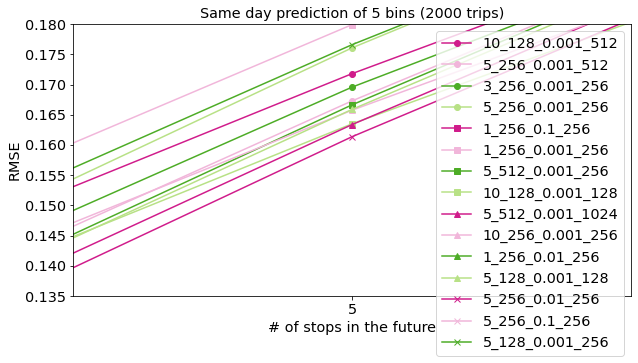

In [52]:
import matplotlib.pyplot as plt
# Plot ave MSE
fig, ax = plt.subplots(figsize=(10, 5))

marker = ['o', 's', '^', 'x']
color = ['#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4']
linestyle = '-'
for i, line in enumerate(res_arr):
    res_arr[i][['mse_1', 'mse_5', 'mse_10', 'mse']].mean().plot(ax=ax, marker=output[i][0], color=output[i][1], linestyle='-', label=res_arr[i]['filename'].values[0])
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels[1] = 1
labels[3] = 5
labels[5] = 10
labels[7] = 'ALL'

ax.set_xticklabels(labels)

ax.set_ylabel('RMSE')
ax.set_xlabel('# of stops in the future')

ax.set_ylim(0.135, 0.18)
ax.set_xlim(0.8, 1.2)
ax.legend()
ax.set_title("Same day prediction of 5 bins (2000 trips)")


In [53]:
## With baseline

In [54]:
## Separate mean and max from baseline
fp = os.path.join('evaluation', 'same_day', 'baseline_multi_stop_10P_xF_results_max_mean.pkl')
df = pd.read_pickle(fp)
df = df.bfill()

df_max = df[['trip_id', 'y_true', 'y_pred_max']]
df_max = df_max.rename({'y_pred_max':'y_pred'}, axis=1)
fp = os.path.join('evaluation', 'same_day', 'baseline_multi_stop_10P_xF_results_max.pkl')
df_max.to_pickle(fp)

df_mean = df[['trip_id', 'y_true', 'y_pred_ave']]
df_mean = df_mean.rename({'y_pred_ave':'y_pred'}, axis=1)
fp = os.path.join('evaluation', 'same_day', 'baseline_multi_stop_10P_xF_results_mean.pkl')
df_mean.to_pickle(fp)

fp = os.path.join('evaluation', 'same_day', 'simple_baseline_multi_stop_10P_xF_results_school_break.pkl')
df_simple = pd.read_pickle(fp)

# fp = os.path.join('evaluation', 'same_day', 'SIMPLE_LSTM_multi_stop_5P_xF_results_school_break.pkl')
fp = os.path.join('/home/jptalusan/mta_stationing_problem/models/same_day/gridsearch/5_256_0.01_256/EVAL_5_256_0.01_256.pkl')
df_lstm = pd.read_pickle(fp)

In [55]:
df_lstm_arr = []
for trip_id in df_simple.trip_id.unique():
    tdf = df_simple.query("trip_id == @trip_id")
    if len(tdf) >= 10:
        tdf = tdf[0:10]
        tdf['y_true'] = pd.to_numeric(tdf['y_true'], errors='coerce')
        tdf['y_pred'] = pd.to_numeric(tdf['y_pred'], errors='coerce')
        tdf['unique_id'] = tdf['trip_id']
        tdf[['trip_id', 'transit_date']] = tdf['trip_id'].str.split('_', 1, expand=True)
        tdf['error'] = abs(tdf['y_true'] - tdf['y_pred'])
        tdf['stop'] = range(1, 11)
        df_lstm_arr.append(tdf)
df_lstm_arr = pd.concat(df_lstm_arr)

In [56]:
df_lstm_arr['transit_date'] = pd.to_datetime(df_lstm_arr['transit_date'])

In [57]:
df_lstm_arr['month'] = df_lstm_arr['transit_date'].dt.month

In [58]:
stop_count_df = df_lstm_arr.groupby(['stop', 'error']).count().reset_index()
stop_count_df.head()

stop  error  trip_id  y_true  y_pred  unique_id  transit_date  month
0     1    0.0     1495    1495    1495       1495          1495   1495
1     1    1.0      291     291     291        291           291    291
2     1    2.0       28      28      28         28            28     28
3     2    0.0     1507    1507    1507       1507          1507   1507
4     2    1.0      277     277     277        277           277    277

In [59]:
import plotly.express as px
fig = px.bar(stop_count_df, x="stop", y="trip_id", color="error")
fig.show()

In [60]:
month_stop_count_df = df_lstm_arr.groupby(['stop', 'error', 'month']).count().reset_index()
month_stop_count_df

stop  error  month  trip_id  y_true  y_pred  unique_id  transit_date
0       1    0.0      1      259     259     259        259           259
1       1    0.0      2      269     269     269        269           269
2       1    0.0      3      317     317     317        317           317
3       1    0.0      4       56      56      56         56            56
4       1    0.0     10        7       7       7          7             7
..    ...    ...    ...      ...     ...     ...        ...           ...
186    10    2.0      2        7       7       7          7             7
187    10    2.0      3        8       8       8          8             8
188    10    2.0      4        1       1       1          1             1
189    10    2.0     11        3       3       3          3             3
190    10    2.0     12        2       2       2          2             2

[191 rows x 8 columns]

In [61]:
import plotly.express as px
fig = px.bar(month_stop_count_df, x="stop", y="trip_id", color="error", facet_col='month', facet_col_wrap=4)
fig.show()

In [62]:
df_lstm['y_true'] = pd.to_numeric(df_lstm['y_true'], errors='coerce')
df_lstm['y_pred'] = pd.to_numeric(df_lstm['y_pred'], errors='coerce')
df_lstm[['trip_id', 'transit_date']] = df_lstm['trip_id'].str.split('_', 1, expand=True)
df_lstm['error'] = abs(df_lstm['y_true'] - df_lstm['y_pred'])

In [63]:
df_lstm

trip_id  y_true  y_pred transit_date  error
0   268878     1.0       1   2022-04-04    0.0
1   268878     1.0       1   2022-04-04    0.0
2   268878     1.0       1   2022-04-04    0.0
3   268878     1.0       1   2022-04-04    0.0
4   268878     1.0       1   2022-04-04    0.0
..     ...     ...     ...          ...    ...
20  262700     0.0       1   2021-12-29    1.0
21  262700     0.0       1   2021-12-29    1.0
22  262700     0.0       1   2021-12-29    1.0
23  262700     0.0       1   2021-12-29    1.0
24  262700     0.0       1   2021-12-29    1.0

[54653 rows x 5 columns]

In [64]:
df_lstm.query("trip_id == '263405_2021-10-31'")

Empty DataFrame
Columns: [trip_id, y_true, y_pred, transit_date, error]
Index: []

In [65]:
f = os.path.join('data', 'processed', 'apc_weather_gtfs.parquet')
apcdata = spark.read.load(f)
apcdata.columns

['gtfs_date',
 'dayofweek',
 'hour',
 'gtfs_route_id',
 'gtfs_direction_id',
 'stop_id',
 'transit_date',
 'trip_id',
 'day',
 'overload_id',
 'vehicle_id',
 'block_abbr',
 'activation_date',
 'activation_date_str',
 'arrival_time',
 'arrival_time_str',
 'block_stop_order',
 'deactivation_date',
 'deactivation_date_str',
 'departure_time',
 'departure_time_str',
 'load',
 'load_factor',
 'map_latitude',
 'map_longitude',
 'offs',
 'ons',
 'pattern_num',
 'route_direction_name',
 'route_id',
 'scheduled_time',
 'scheduled_time_str',
 'source_pattern_id',
 'stop_id_list',
 'stop_id_original',
 'stop_name',
 'stop_sequence',
 'stop_sequence_list',
 'transit_date_str',
 'update_date',
 'vehicle_capacity',
 'zero_load_at_trip_end',
 'count',
 'darksky_temperature',
 'darksky_humidity',
 'darksky_nearest_storm_distance',
 'darksky_precipitation_intensity',
 'darksky_precipitation_probability',
 'darksky_pressure',
 'darksky_wind_gust',
 'darksky_wind_speed',
 'weatherbit_rh',
 'weatherbit_wi

In [66]:
f = os.path.join('data', 'processed', 'apc_weather_gtfs.parquet')
apcdata = spark.read.load(f)
todelete = apcdata.filter('(load < 0) OR (load IS NULL)').select('transit_date','trip_id','overload_id').distinct()
todelete=todelete.withColumn('marker',F.lit(1))

#joining and whereever the records are not found in sync error table the marker will be null
apcdataafternegdelete=apcdata.join(todelete,on=['trip_id','transit_date','overload_id'],how='left').filter('marker is null').drop('marker')
apcdataafternegdelete = apcdataafternegdelete.sort(['trip_id', 'overload_id'])
get_columns = ['trip_id', 'transit_date', 'arrival_time', 
               'year', 'month', 'hour', 'overload_id']
get_str = ", ".join([c for c in get_columns])

apcdataafternegdelete.createOrReplaceTempView("apc")

# # filter subset
query = f"""
SELECT {get_str}
FROM apc
"""

apcdataafternegdelete = spark.sql(query)
apcdataafternegdelete

DataFrame[trip_id: string, transit_date: timestamp, arrival_time: timestamp, year: int, month: int, hour: int, overload_id: int]

In [67]:
# df_lstm[['trip_id', 'transit_date']] = df_lstm['trip_id'].str.split('_', 1, expand=True)

In [68]:
spark_lstm = spark.createDataFrame(df_lstm) 

In [69]:
# Merge
spark_lstm = spark_lstm.join(apcdataafternegdelete, on=['transit_date', 'trip_id'], how='inner')

In [70]:
df_lstm = spark_lstm.toPandas()

In [71]:
df_lstm.shape

(2107200, 10)

In [72]:
df_lstm.drop_duplicates()

transit_date trip_id  y_true  y_pred  error        arrival_time  year  \
0         2021-10-31  263405     2.0       2    0.0 2021-10-31 10:57:20  2021   
1         2021-10-31  263405     2.0       2    0.0 2021-10-31 10:20:26  2021   
2         2021-10-31  263405     2.0       2    0.0 2021-10-31 10:39:10  2021   
3         2021-10-31  263405     2.0       2    0.0 2021-10-31 10:29:56  2021   
4         2021-10-31  263405     2.0       2    0.0 2021-10-31 10:42:58  2021   
...              ...     ...     ...     ...    ...                 ...   ...   
2103979   2022-03-24  260360     0.0       0    0.0 2022-03-24 08:25:38  2022   
2103980   2022-03-24  260360     0.0       0    0.0 2022-03-24 09:01:21  2022   
2103981   2022-03-24  260360     0.0       0    0.0 2022-03-24 08:36:22  2022   
2103982   2022-03-24  260360     0.0       0    0.0 2022-03-24 08:23:14  2022   
2103983   2022-03-24  260360     0.0       0    0.0 2022-03-24 08:36:34  2022   

         month  hour  overload_id  
0           10  10.0            0  
1           10  10.0            0  
2           10  10.0            0  
3           10  10.0            0  
4           10  10.0            0  
...        ...   ...          ...  
2103979      3   8.0            0  
2103980      3   9.0            0  
2103981      3   8.0            0  
2103982      3   8.0            0  
2103983      3   8.0            0  

[125432 rows x 10 columns]

In [73]:
df_lstm['y_true'] = pd.to_numeric(df_lstm['y_true'], errors='coerce')
df_lstm['y_pred'] = pd.to_numeric(df_lstm['y_pred'], errors='coerce')
df_lstm['error'] = abs(df_lstm['y_true'] - df_lstm['y_pred'])

In [74]:
for trip_id, trip_id_df in df_lstm.groupby(['trip_id', 'transit_date']):
    trip_id_df['stop'] = range(len(trip_id_df))
    

In [75]:
df_lstm.drop_duplicates().query("transit_date == '2021-10-31' and trip_id == '263405'")

transit_date trip_id  y_true  y_pred  error        arrival_time  year  \
0    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:57:20  2021   
1    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:20:26  2021   
2    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:39:10  2021   
3    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:29:56  2021   
4    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:42:58  2021   
5    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:32:40  2021   
6    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:30:54  2021   
7    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:52:42  2021   
8    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:03:34  2021   
9    2021-10-31  263405     2.0       2    0.0 2021-10-31 10:46:28  2021   
10   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:53:16  2021   
11   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:49:06  2021   
12   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:40:54  2021   
13   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:33:30  2021   
14   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:54:00  2021   
15   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:51:32  2021   
16   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:45:10  2021   
17   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:26:10  2021   
18   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:28:06  2021   
19   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:56:52  2021   
20   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:19:26  2021   
21   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:23:06  2021   
22   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:56:10  2021   
23   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:31:52  2021   
24   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:15:54  2021   
25   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:25:20  2021   
26   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:33:14  2021   
27   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:27:04  2021   
28   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:44:04  2021   
29   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:43:26  2021   
30   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:54:48  2021   
31   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:24:55  2021   
32   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:45:36  2021   
33   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:50:32  2021   
34   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:39:52  2021   
35   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:53:40  2021   
36   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:18:02  2021   
37   2021-10-31  263405     2.0       2    0.0 2021-10-31 10:37:58  2021   

    month  hour  overload_id  
0      10  10.0            0  
1      10  10.0            0  
2      10  10.0            0  
3      10  10.0            0  
4      10  10.0            0  
5      10  10.0            0  
6      10  10.0            0  
7      10  10.0            0  
8      10  10.0            0  
9      10  10.0            0  
10     10  10.0            0  
11     10  10.0            0  
12     10  10.0            0  
13     10  10.0            0  
14     10  10.0            0  
15     10  10.0            0  
16     10  10.0            0  
17     10  10.0            0  
18     10  10.0            0  
19     10  10.0            0  
20     10  10.0            0  
21     10  10.0            0  
22     10  10.0            0  
23     10  10.0            0  
24     10  10.0            0  
25     10  10.0            0  
26     10  10.0            0  
27     10  10.0            0  
28     10  10.0            0  
29     10  10.0            0  
30     10  10.0            0  
31     10  10.0            0  
32     10  10.0

In [76]:
import pickle
fp = os.path.join('models/same_day/evaluation/random_trip_ids_2000.pkl')
with open(fp, 'rb') as f:
    random_trip_ids = pickle.load(f)
random_trip_ids

['268878_2022-04-04',
 '260460_2021-11-05',
 '260470_2021-12-09',
 '263164_2022-03-24',
 '264621_2022-01-15',
 '260082_2022-03-22',
 '262651_2021-12-09',
 '259794_2022-01-19',
 '260051_2022-03-14',
 '260501_2022-01-19',
 '263252_2021-12-20',
 '264039_2021-12-29',
 '260836_2021-12-15',
 '264053_2022-01-04',
 '262167_2021-11-01',
 '263411_2021-12-24',
 '260458_2022-01-10',
 '259452_2022-03-04',
 '261646_2022-02-18',
 '262711_2022-03-08',
 '262349_2022-01-18',
 '264599_2022-02-15',
 '259632_2022-01-14',
 '264770_2022-03-24',
 '260978_2022-03-02',
 '263901_2021-11-07',
 '263234_2022-02-03',
 '264596_2022-01-04',
 '264602_2022-04-02',
 '264312_2022-01-30',
 '264559_2022-03-18',
 '264417_2021-12-20',
 '259747_2021-12-21',
 '259754_2022-03-16',
 '262478_2021-11-20',
 '260101_2021-11-05',
 '264771_2022-01-04',
 '260025_2022-01-18',
 '260472_2021-12-01',
 '259443_2022-01-04',
 '264437_2022-01-11',
 '263262_2022-02-15',
 '268050_2022-04-05',
 '260245_2021-11-14',
 '264180_2022-02-14',
 '263584_2

In [77]:
res_df_arr = []
multi_stop_results = ['SIMPLE_LSTM_multi_stop_5P_xF_results_school_break.pkl', 
                      'simple_baseline_multi_stop_10P_xF_results_school_break.pkl',
                      'baseline_multi_stop_10P_xF_results_max.pkl',
                      'baseline_multi_stop_10P_xF_results_mean.pkl']
for ms_result in multi_stop_results:
    fp = os.path.join('evaluation/same_day/', ms_result)
    res_df = pd.read_pickle(fp)[:200].bfill()
    res_df = res_df.groupby('trip_id').agg(list)
    res_df['mse'] = res_df.apply(lambda x: get_mse(x), axis=1)
    res_df['mse_1'] = res_df.apply(lambda x: get_mse(x, 1), axis=1)
    res_df['mse_5'] = res_df.apply(lambda x: get_mse(x, 5), axis=1)
    res_df['mse_10'] = res_df.apply(lambda x: get_mse(x, 10), axis=1)
    res_df_arr.append(res_df)

In [78]:
res_df_arr[0]

y_true  \
trip_id                                                                
259794_2022-01-19  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
260082_2022-03-22  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
260460_2021-11-05  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
260470_2021-12-09  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
262651_2021-12-09  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
263164_2022-03-24  [2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, ...   
264621_2022-01-15  [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...   
268878_2022-04-04  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                              y_pred  \
trip_id                                                                
259794_2022-01-19  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
260082_2022-03-22  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
260460_2021-11-05  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
260470_2021-12-09  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
262651_2021-12-09  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
263164_2022-03-24  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
264621_2022-01-15  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
268878_2022-04-04  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                        mse  mse_1     mse_5    mse_10  
trip_id                                                 
259794_2022-01-19  0.577350    0.0  0.000000  0.000000  
260082_2022-03-22  0.000000    0.0  0.000000  0.000000  
260460_2021-11-05  1.315587    0.0  0.000000  0.000000  
260470_2021-12-09  0.000000    0.0  0.000000  0.000000  
262651_2021-12-09  0.605530    0.0  0.000000  0.000000  
263164_2022-03-24  0.816497    0.0  1.788854  1.414214  
264621_2022-01-15  0.000000    0.0  0.000000  0.000000  
268878_2022-04-04  0.674200    0.0  0.000000  0.000000

['', 'mse_1', '', 'mse_5', '', 'mse_10', '', 'mse', '']


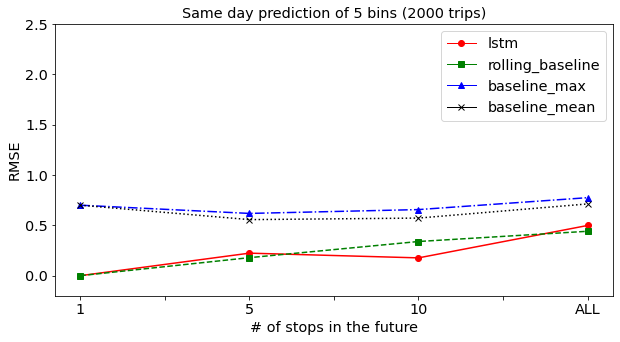

In [79]:
import matplotlib.pyplot as plt
# Plot ave MSE
fig, ax = plt.subplots(figsize=(10, 5))

marker = ['o', 's', '^', 'x']
color = ['r', 'g', 'b', 'k']
linestyle = ['-', '--', '-.', ':']
for i, line in enumerate(res_df_arr):
    
    res_df_arr[i][['mse_1', 'mse_5', 'mse_10', 'mse']].mean().plot(ax=ax, marker=marker[i], color=color[i], linestyle=linestyle[i])
    # line.set_marker(marker[i])
    # line.set_color(color[i])
#     # line.set_linestyle(linestyle[i])
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels[1] = 1
labels[3] = 5
labels[5] = 10
labels[7] = 'ALL'

ax.set_xticklabels(labels)

ax.set_ylabel('RMSE')
ax.set_xlabel('# of stops in the future')
from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], color='red', lw=1, marker='o'),
                Line2D([0], [0], color='green', lw=1, marker='s'),
                Line2D([0], [0], color='blue', lw=1, marker='^'),
                Line2D([0], [0], color='k', lw=1, marker='x'),
               ]
ax.set_ylim(-0.2, 2.5)
ax.legend(custom_lines, ['lstm', 'rolling_baseline', 'baseline_max', 'baseline_mean'])
ax.set_title("Same day prediction of 5 bins (2000 trips)")
fp = os.path.join('plots', 'stop_level_prediction.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

### Evaluating using MAPE

In [80]:
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107200 entries, 0 to 2107199
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   transit_date  object        
 1   trip_id       object        
 2   y_true        float64       
 3   y_pred        int64         
 4   error         float64       
 5   arrival_time  datetime64[ns]
 6   year          int32         
 7   month         int32         
 8   hour          float64       
 9   overload_id   int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(2)
memory usage: 136.7+ MB


In [81]:
# Try to get nth element instead of first or last

In [82]:
df_lstm['y_true'] = pd.to_numeric(df_lstm['y_true'], errors='coerce')
df_lstm['y_pred'] = pd.to_numeric(df_lstm['y_pred'], errors='coerce')
df_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107200 entries, 0 to 2107199
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   transit_date  object        
 1   trip_id       object        
 2   y_true        float64       
 3   y_pred        int64         
 4   error         float64       
 5   arrival_time  datetime64[ns]
 6   year          int32         
 7   month         int32         
 8   hour          float64       
 9   overload_id   int32         
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(2)
memory usage: 136.7+ MB


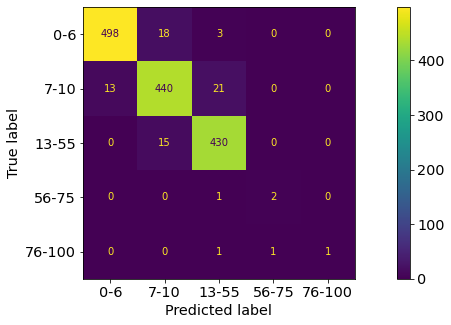

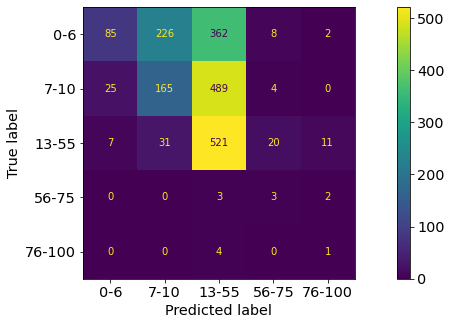

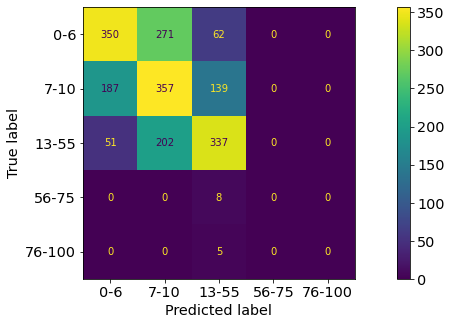

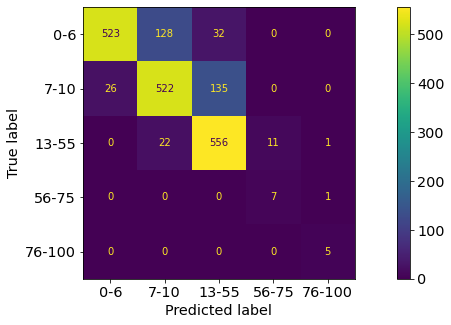

In [83]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# print(classification_report(df_lstm['y_true'], df_lstm['y_pred']))
# print(classification_report(df_max['y_true'], df_max['y_pred']))
# print(classification_report(df_mean['y_true'], df_mean['y_pred']))
# print(classification_report(df_simple['y_true'], df_simple['y_pred']))

# labels = [(0.0, 6.0), (7.0, 12.0), (13.0, 55.0), (56.0, 75.0), (76.0, 100.0)]
labels = ["0-6", "7-10", "13-55", "56-75", "76-100"]
# ConfusionMatrixDisplay.from_predictions(df_lstm['y_true'], df_lstm['y_pred'], values_format = 'd')#, display_labels=labels)
# ConfusionMatrixDisplay.from_predictions(df_max['y_true'], df_max['y_pred'], values_format = 'd')#, display_labels=labels)
# ConfusionMatrixDisplay.from_predictions(df_mean['y_true'], df_mean['y_pred'], values_format = 'd')#, display_labels=labels)
# ConfusionMatrixDisplay.from_predictions(df_simple['y_true'], df_simple['y_pred'], values_format = 'd')#, display_labels=labels)

ConfusionMatrixDisplay.from_predictions(df_lstm.groupby('trip_id').first()['y_true'], df_lstm.groupby('trip_id').first()['y_pred'], values_format = 'd', display_labels=labels)
plt.savefig('plots/simple_lstm_first_CM.png', dpi=200, bbox_inches='tight')
ConfusionMatrixDisplay.from_predictions(df_max.groupby('trip_id').first()['y_true'], df_max.groupby('trip_id').first()['y_pred'], values_format = 'd', display_labels=labels)
plt.savefig('plots/baseline_max_first_CM.png', dpi=200, bbox_inches='tight')
ConfusionMatrixDisplay.from_predictions(df_mean.groupby('trip_id').first()['y_true'], df_mean.groupby('trip_id').first()['y_pred'], values_format = 'd', display_labels=labels)
plt.savefig('plots/baseline_mean_lstm_first_CM.png', dpi=200, bbox_inches='tight')
ConfusionMatrixDisplay.from_predictions(df_simple.groupby('trip_id').first()['y_true'], df_simple.groupby('trip_id').first()['y_pred'], values_format = 'd', display_labels=labels)
plt.savefig('plots/baseline_roll_first_CM.png', dpi=200, bbox_inches='tight')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape_lstm = mean_absolute_percentage_error(df_lstm['y_true'], df_lstm['y_pred'])
mape_simple = mean_absolute_percentage_error(df_simple['y_true'], df_simple['y_pred'])
mape_base_max = mean_absolute_percentage_error(df_max['y_true'], df_max['y_pred'])
mape_base_mean = mean_absolute_percentage_error(df_mean['y_true'], df_mean['y_pred'])
print(f"{mape_lstm:.2E}, {mape_simple:.2E}, {mape_base_max:.2E}, {mape_base_mean:.2E}")

# Comparing Day Ahead and Any Day with baselines

In [ ]:
# Define evaluator, requires some time information (merge testX, testY and pred)
def generate_results_over_time_window(results_df_arr):
    mse_df = pd.DataFrame()
    for i, results_df in enumerate(results_df_arr):
        tdf = results_df[['time_window', 'y_pred', 'y_true']].groupby('time_window').agg({'y_pred': list, 'y_true': list})
        tdf['mse'] = tdf.apply(lambda x: mean_squared_error(x.y_true, x.y_pred, squared=False), axis=1)
        mse_df[i] = tdf['mse']
    return mse_df

## Day Ahead

In [ ]:
labels = ["0-6", "7-10", "13-55", "56-75", "76-100"]

Text(0.5, 1.0, 'Day ahead')

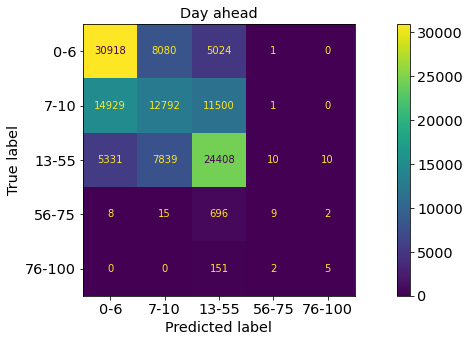

In [85]:
fp = os.path.join('evaluation', 'day_ahead_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(mse_df_012.query("kfold==1").y_true, mse_df_012.query("kfold==1").y_pred, display_labels=labels, ax=ax)
ax.set_title('Day ahead')

In [ ]:
fp = os.path.join('evaluation', 'any_day_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(mse_df_012.query("kfold==1").y_true, mse_df_012.query("kfold==1").y_pred, display_labels=labels, ax=ax)
ax.set_title('Any day')

In [ ]:
fp = os.path.join('evaluation', 'baseline_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(mse_df_012.query("past==1").y_true, mse_df_012.query("past==1").y_pred, display_labels=labels, values_format='d', ax=ax)
ax.set_title('Baseline 1 week')

In [ ]:
fp = os.path.join('evaluation', 'day_ahead_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)
# fp = os.path.join('evaluation', 'day_ahead_234_raw_results.pkl')
# mse_df_234 = pd.read_pickle(fp)
# mse_df_234['y_true'] = mse_df_234['y_true'] + 2
# mse_df_234['y_pred'] = mse_df_234['y_pred'] + 2
# mse_df = pd.concat([mse_df_012.query('y_true < 2'), mse_df_234])

mse_df = mse_df_012
mse_df['error'] = abs(mse_df['y_true'] - mse_df['y_pred'])
print(mse_df.query('kfold == 1').shape)
mse_df = mse_df.groupby(['time_window', 'kfold', 'error']).count().reset_index()
# fig = px.bar(mse_df, x="time_window", y="y_true", color="error", facet_row='kfold')
mse_df = mse_df.query('kfold == 0')
fig = px.bar(mse_df, x="time_window", y="y_true", color="error")
fig.update_layout(title='Day ahead',
                  yaxis_range=[0, 5000],
                  yaxis_title='count',
                  xaxis = dict(
                        tickmode = 'array',
                        tickvals = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                        ticktext = ['00:00-00:30', '2:30-3:00', '5:00-5:30', '7:30-8:00', '10:00-10:30', '12:30-13:00', '15:00-15:30', '17:30-18:00', '20:00-20:30', '22:30-23:00']
                    ))
fig.show()


In [ ]:
fp = os.path.join('evaluation', 'any_day_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'any_day_234_raw_results.pkl')
mse_df_234 = pd.read_pickle(fp)
# mse_df_234['y_true'] = mse_df_234['y_true'] + 2
# mse_df_234['y_pred'] = mse_df_234['y_pred'] + 2
# mse_df = pd.concat([mse_df_012.query('y_true < 2'), mse_df_234])

mse_df = mse_df_012
mse_df['error'] = abs(mse_df['y_true'] - mse_df['y_pred'])
print(mse_df.query('kfold == 1').shape)
mse_df = mse_df.groupby(['time_window', 'kfold', 'error']).count().reset_index()
# fig = px.bar(mse_df, x="time_window", y="y_true", color="error", facet_row='kfold')
mse_df = mse_df.query('kfold == 0')
fig = px.bar(mse_df, x="time_window", y="y_true", color="error")
fig.update_layout(title='Any day',
                  yaxis_range=[0, 5000],
                  yaxis_title='count',
                  xaxis = dict(
                        tickmode = 'array',
                        tickvals = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                        ticktext = ['00:00-00:30', '2:30-3:00', '5:00-5:30', '7:30-8:00', '10:00-10:30', '12:30-13:00', '15:00-15:30', '17:30-18:00', '20:00-20:30', '22:30-23:00']
                    ))
fig.show()

In [ ]:
fp = os.path.join('evaluation', 'any_day_012_raw_results.pkl')
mse_df = pd.read_pickle(fp)
mse_df = mse_df.query('kfold == 1')
mse_df

In [ ]:
fp = os.path.join('evaluation', 'baseline_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'baseline_234_raw_results.pkl')
mse_df_234 = pd.read_pickle(fp)
# mse_df_234['y_true'] = mse_df_234['y_true'] + 2
# mse_df_234['y_pred'] = mse_df_234['y_pred'] + 2
# mse_df = pd.concat([mse_df_012.query('y_true < 2'), mse_df_234])

mse_df = mse_df_012
mse_df['error'] = abs(mse_df['y_true'] - mse_df['y_pred'])
mse_df = mse_df.groupby(['time_window', 'past', 'error']).count().reset_index()
# fig = px.bar(mse_df, x="time_window", y="y_true", color="error", facet_row='past')
mse_df = mse_df.query('past == 1')
fig = px.bar(mse_df, x="time_window", y="y_true", color="error")
fig.update_layout(title='Baseline',
                  yaxis_range=[0, 5000],
                  yaxis_title='count',
                  xaxis = dict(
                        tickmode = 'array',
                        tickvals = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                        ticktext = ['00:00-00:30', '2:30-3:00', '5:00-5:30', '7:30-8:00', '10:00-10:30', '12:30-13:00', '15:00-15:30', '17:30-18:00', '20:00-20:30', '22:30-23:00']
                    ))

fig.show()

In [86]:
fp = os.path.join('evaluation', 'day_ahead_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)

mse_df_012['error'] = abs(mse_df_012['y_true'] - mse_df_012['y_pred'])
mse_df_012 = mse_df_012.query('kfold == 0')
# mse_df
fig = px.box(mse_df_012, x="time_window", y="error", points='all')
# fig.update_layout(title='Day ahead')
fig.write_image("plots/day_ahead_box.png")

In [ ]:
fp = os.path.join('evaluation', 'baseline_012_raw_results.pkl')
mse_df_012 = pd.read_pickle(fp)

mse_df_012['error'] = abs(mse_df_012['y_true'] - mse_df_012['y_pred'])
mse_df_012 = mse_df_012.query('past == 1')

# mse_df
fig = px.box(mse_df_012, x="time_window", y="error", points='all')
# fig.update_layout(title='Baseline')
fig.write_image("plots/baseline_box.png")

In [99]:
import numpy as np

[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


/tmp/ipykernel_90295/1325034378.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



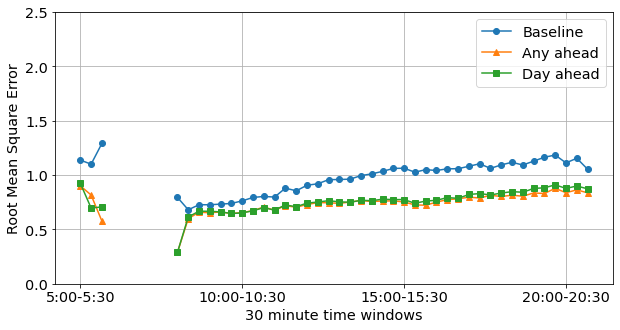

In [109]:
import matplotlib.ticker as ticker
# Plotting all three with their minimums
fp = os.path.join('evaluation', 'day_ahead', 'done', 'day_ahead_012_results_schoolbreak.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_day_ahead_012_results_schoolbreak.pkl')
mse_day_ahead_df = pd.read_pickle(fp)
mse_day_ahead_df['min'] = mse_day_ahead_df.min(axis=1)
mse_day_ahead_df.replace(to_replace = 0, value = np.nan, inplace=True)
fp = os.path.join('evaluation',  'day_ahead', 'done', 'any_day_012_results_schoolbreak.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_any_day_012_results_schoolbreak.pkl')
mse_any_day_df = pd.read_pickle(fp)
mse_any_day_df['min'] = mse_any_day_df.min(axis=1)
mse_any_day_df.replace(to_replace = 0, value = np.nan, inplace=True)

fp = os.path.join('evaluation', 'day_ahead', 'done',  'baseline_012_results.pkl')
mse_baseline_df = pd.read_pickle(fp)
mse_baseline_df['min'] = mse_baseline_df.max(axis=1)
mse_baseline_df.replace(to_replace = 0, value = np.nan, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mse_baseline_df['min'], marker='o', label='Baseline')
ax.plot(mse_any_day_df['min'], marker='^', label='Any ahead')
ax.plot(mse_day_ahead_df['min'], marker='s', label='Day ahead')
ax.set_ylim(0, 2.5)
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.grid()
ax.legend()
xticks = ax.get_xticklabels()
print(xticks)
# time_strs = []
# for xtick in xticks:
#     try:
#         val = int(xtick.get_text())
#     except:
#         continue
#     hour = val // (60 // 30)
#     minute = 0
#     if val % 2:
#         minute = 30
#     time_str = f"{str(hour).zfill(2)}:{str(minute).zfill(2)}"
#     time_strs.append(time_str)
# time_strs = list(zip(time_strs[0:], time_strs[1:]))
# time_strs.append(('23:30', '00:00'))
# time_strs = [f"{ts[0]}-{ts[1]}" for ts in time_strs]
# ax.set_xticklabels(time_strs)
ax.set_xticklabels(['00:00-00:30', '5:00-5:30', '10:00-10:30', '15:00-15:30', '20:00-20:30'])

loc = ticker.MultipleLocator(base=15.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

fp = os.path.join('plots', 'day_ahead.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

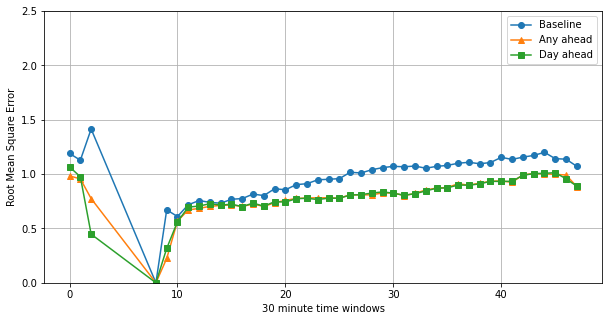

In [7]:
# Plotting all three with their minimums
fp = os.path.join('evaluation', 'day_ahead_012_results_notOHE_tw.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_day_ahead_012_results_schoolbreak.pkl')
mse_day_ahead_df = pd.read_pickle(fp)
mse_day_ahead_df['min'] = mse_day_ahead_df.min(axis=1)

fp = os.path.join('evaluation',  'any_day_012_results_notOHE_tw.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_any_day_012_results_schoolbreak.pkl')
mse_any_day_df = pd.read_pickle(fp)
mse_any_day_df['min'] = mse_any_day_df.min(axis=1)

fp = os.path.join('evaluation',  'baseline_012_results.pkl')
mse_baseline_df = pd.read_pickle(fp)
mse_baseline_df['min'] = mse_baseline_df.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mse_baseline_df['min'], marker='o', label='Baseline')
ax.plot(mse_any_day_df['min'], marker='^', label='Any ahead')
ax.plot(mse_day_ahead_df['min'], marker='s', label='Day ahead')
ax.set_ylim(0, 2.5)
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.grid()
ax.legend()
fp = os.path.join('plots', 'day_ahead.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [ ]:
mse_baseline_df

## Working code below

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
fp = os.path.join('evaluation', 'day_ahead', 'day_ahead_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'day_ahead_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_df = mse_df_012 + mse_df_234

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Day Ahead")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_schoolbreak.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

## Any Ahead

In [ ]:
fp = os.path.join('evaluation', 'day_ahead', 'any_day_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'any_day_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_df = mse_df_012 + mse_df_234

fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Day Ahead")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'any_day_schoolbreak.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

## Baseline

In [ ]:
fp = os.path.join('evaluation', 'day_ahead', 'baseline_012_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead', 'baseline_234_results.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_df = mse_df_012 + mse_df_234

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
mse_df['time_window'] = mse_df.index
mse_df['time_window'].to_numpy()
mse_df['time_window'] = mse_df['time_window'].to_numpy().astype('int')
mse_df = mse_df.reset_index(drop=True).set_index('time_window')

mse_df.T.boxplot(ax=ax)

ax.set_title("Baseline")
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.set_ylim(0.0, 2.5)

fp = os.path.join('plots', 'day_ahead_baseline.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

In [6]:
# Plotting all three with their minimums
fp = os.path.join('evaluation', 'day_ahead_012_results_notOHE_tw.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_day_ahead_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation', 'day_ahead_234_results_notOHE_tw.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_day_ahead_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_day_ahead_df = mse_df_012 + mse_df_234
mse_day_ahead_df['min'] = mse_day_ahead_df.min(axis=1)

fp = os.path.join('evaluation',  'any_day_012_results_notOHE_tw.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_any_day_012_results_schoolbreak.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation',  'any_day_234_results_notOHE_tw.pkl')
# fp = os.path.join('evaluation', 'no_speed_simple_any_day_234_results_schoolbreak.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_any_day_df = mse_df_012 + mse_df_234
mse_any_day_df['min'] = mse_any_day_df.min(axis=1)

fp = os.path.join('evaluation',  'baseline_012_results.pkl')
mse_df_012 = pd.read_pickle(fp)
fp = os.path.join('evaluation',  'baseline_234_results.pkl')
mse_df_234 = pd.read_pickle(fp)
mse_baseline_df = mse_df_012 + mse_df_234
mse_baseline_df['min'] = mse_baseline_df.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mse_baseline_df['min'], marker='o', label='Baseline')
ax.plot(mse_any_day_df['min'], marker='^', label='Any ahead')
ax.plot(mse_day_ahead_df['min'], marker='s', label='Day ahead')
ax.set_ylim(0, 2.5)
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("30 minute time windows")
ax.grid()
ax.legend()
fp = os.path.join('plots', 'day_ahead.png')
plt.savefig(fp, dpi=200, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation/day_ahead_234_results_notOHE_tw.pkl'

In [ ]:
mse_baseline_df
mse_any_day_df
mse_day_ahead_df

In [ ]:
mse_day_ahead_df.index

In [ ]:
import plotly.graph_objects as go
import numpy as np

In [ ]:
x = mse_baseline_df.index.tolist()
x_rev = x[::-1]
print(x + x_rev)
mse_baseline_y     = mse_baseline_df.median(axis=1).tolist()
mse_baseline_lower = mse_baseline_df.min(axis=1).tolist()
mse_baseline_upper = mse_baseline_df.max(axis=1).tolist()
mse_baseline_lower = mse_baseline_lower[::-1]

mse_any_day_y     = mse_any_day_df.median(axis=1).tolist()
mse_any_day_lower = mse_any_day_df.min(axis=1).tolist()
mse_any_day_upper = mse_any_day_df.max(axis=1).tolist()
mse_any_day_lower = mse_any_day_lower[::-1]

mse_day_ahead_y     = mse_day_ahead_df.median(axis=1).tolist()
mse_day_ahead_lower = mse_day_ahead_df.min(axis=1).tolist()
mse_day_ahead_upper = mse_day_ahead_df.max(axis=1).tolist()
mse_day_ahead_lower = mse_day_ahead_lower[::-1]


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=mse_baseline_upper+mse_baseline_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Baseline',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=mse_any_day_upper+mse_any_day_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Any Day',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=mse_day_ahead_upper+mse_day_ahead_lower,
    fill='toself',
    fillcolor='rgba(231,107,243,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Day Ahead',
))
fig.add_trace(go.Scatter(
    x=x, y=mse_baseline_y,
    line_color='rgb(0,100,80)',
    name='Baseline',
))
fig.add_trace(go.Scatter(
    x=x, y=mse_any_day_y,
    line_color='rgb(0,176,246)',
    name='Any Day',
))
fig.add_trace(go.Scatter(
    x=x, y=mse_day_ahead_y,
    line_color='rgb(231,107,243)',
    name='Day Ahead',
))

fig.update_traces(mode='lines+markers')
fig.show()
